# Workforce Analytics Group Assignment - Group 7

## Part 1

In [1]:
# -*- coding: utf-8 -*-

import nltk
from collections import Counter
import codecs
import os.path
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from nltk.stem import WordNetLemmatizer
import random
import re
import jellyfish
import operator

"""
Extract and Extract Verbs Only

"""  

def extract_nouns(text):
    
    # your code goes here
    firm_nouns = []
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for (word, tag) in tags:
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            firm_nouns.append(word.lower())
    
    return firm_nouns

def extract_verbs(text):
    
    # your code goes here
    firm_verbs = []
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for (word, tag) in tags:
        if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            firm_verbs.append(word.lower())
    
    return firm_verbs

"""
Lemmatisation before finding frequent words

"""

def lemmatise(listWords, pos = 'n'):
    lemmaWords = []
    lemmatizer = WordNetLemmatizer()
    for word in listWords:
        lemmaWords.append(lemmatizer.lemmatize(word, pos = pos))
        
    return lemmaWords


"""
Frequent Words

"""

def stop_words(word_list, percentile = 75):
    
    # your code goes here
    new_word_list = []
    stop_list = []
    #freq ={}
    counts = Counter(word_list)
    #numWords = sum(counts.values())
    for key, value in counts.items():
        new_word_list.append(key)
        #freq = value / numWords
        if value > np.percentile(list(counts.values()), percentile):
            stop_list.append(key)
    
    return (new_word_list, stop_list)


"""
Similarity of two lists of words

"""

def intersect(a, b):
    return list(set(a) & set(b))

def union(a, b):
    return list(set(a).union(set(b)))
       
def similarity(lst1, lst2):
    ## your code here
    unionList = union(lst1, lst2)
    if len(unionList) == 0:
        sim = 0
    else:
        sim = len(intersect(lst1, lst2)) / len(unionList)
    
    return sim

"""
Diversity Calculation
Inherent Diversity - Use Ethnicity as Proxy
Acquired Diversity - Use Highest Educational Qualifcation as Proxy

"""

def diversityCalc(lst1, lst2):
    lst1 = np.array(lst1)
    lst2 = np.array(lst2)
    return (1 - (np.sum(lst1 == lst2) / float(len(lst1))))

In [2]:
"""
Read in text files and calculate similarities

"""

groups = [x for x in range(1, 9)]

globalNouns = []
globalVerbs = []
groupNouns = {}
groupVerbs = {}
rawWords = {}

for groupNo in groups:
    
    fname1 = "D:\\Imperial MSc\\Electives\\Workforce Analytics\\Coursework\\cover letters\\group{}.txt".format(groupNo)
    
    if os.path.isfile(fname1):
        with codecs.open(fname1, "r", encoding='utf-8', errors='ignore') as myfile:
            text = myfile.read().replace('\n', '')
            groupNounsList = extract_nouns(text)
            groupVerbsList = extract_verbs(text)
            
            # Lemmatize so that the words with same meaning but different forms (e.g. different tenses) can be matched
            groupNounsList = lemmatise(groupNounsList, pos = 'n')
            groupVerbsList = lemmatise(groupVerbsList, pos = 'v')
            
            groupNouns[groupNo] = groupNounsList
            groupVerbs[groupNo] = groupVerbsList
            globalNouns = globalNouns + groupNounsList
            globalVerbs = globalVerbs + groupVerbsList
            # Remove space and '\r' characters and store into rawWords
            rawWords[groupNo] = re.split(' |\r', text.lower()) # Store raw words to extract ethnicity and education later

# Process Digital Interviewer JD
jdNouns = []
jdVerbs = []
fname2 = "D:\\Imperial MSc\\Electives\\Workforce Analytics\\Coursework\\cover letters\\JD.txt"
if os.path.isfile(fname2):
    with codecs.open(fname2, "r", encoding='utf-8', errors='ignore') as myfile:
        text = myfile.read().replace('\n', '')
        jdNouns = extract_nouns(text)
        jdVerbs = extract_verbs(text)
        # Lemmatize
        jdNouns = lemmatise(jdNouns, pos = 'n')
        jdVerbs = lemmatise(jdVerbs, pos = 'v')
        

In [3]:
"""
Remove StopWords (> 75% percentile)
  
"""

# Use some of the english stop words defined in NLTK
commonStopWords = set(nltk.corpus.stopwords.words('english'))

# Find out stop words from nouns and verbs
uniqGlobalNouns, stopNouns = stop_words(globalNouns, percentile = 75)
uniqGlobalVerbs, stopVerbs = stop_words(globalVerbs, percentile = 75)

globalNounsNoStop = [word for word in uniqGlobalNouns if word not in stopNouns]
globalVerbsNoStop = [word for word in uniqGlobalVerbs if word not in stopVerbs]

groupImptNouns = {}
groupImptVerbs = {}
# Retain important nouns and verbs and store in dictionaries groupNouns and groupVerbs
for key, value in groupNouns.items():
    newGroupNouns = intersect(value, globalNounsNoStop)
    groupImptNouns[key] = newGroupNouns

for key, value in groupVerbs.items():
    newGroupVerbs = intersect(value, globalVerbsNoStop)
    groupImptVerbs[key] = newGroupVerbs

# For JD, we don't filter the words that appear frequently, since they may indicate important job requirements (e.g. Python)
# Thus, we only filter out the common english stop words
jdImptNouns = list(set([word for word in jdNouns if word not in commonStopWords]))
jdImptVerbs = list(set([word for word in jdVerbs if word not in commonStopWords]))

In [4]:
"""
Similarity Network
   
"""

## create all possible edges in a graph
possible_edges = list(itertools.combinations(groups, 2))

# Create a single graph for the 8 applications
G = nx.Graph()
G.add_nodes_from(groups)
jdSimilarity = {}
# Similarity is calculated using BOTH nouns and verbs matching
for groupNo in groups:
    jdSimilarity[groupNo] = similarity(groupImptNouns[groupNo] + groupImptVerbs[groupNo], jdImptNouns + jdImptVerbs)

# Add JD Similarity as 
nx.set_node_attributes(G, 'jdSimilarity', jdSimilarity)
for groupA, groupB in possible_edges:
    groupSimilarity = similarity(groupImptNouns[groupA] + groupImptVerbs[groupA], 
                                 groupImptNouns[groupB] + groupImptVerbs[groupB])
    if groupSimilarity > 0:
        G.add_edge(groupA, groupB, weight = groupSimilarity)

In [5]:
# Add JD Similarity as node attributes
nx.get_node_attributes(G, 'jdSimilarity')

{1: 0.03804347826086957,
 2: 0.04375,
 3: 0.03468208092485549,
 4: 0.04142011834319527,
 5: 0.056451612903225805,
 6: 0.016216216216216217,
 7: 0.026737967914438502,
 8: 0.028735632183908046}

In [6]:
highestThree = sorted(nx.get_node_attributes(G, 'jdSimilarity').items(), key = operator.itemgetter(1), reverse = True)[:3]
highestThree = [node for (node, jdSim) in highestThree]

In [7]:
jdScore = []
for groupNo in groups:
    if groupNo in highestThree:
        jdScore.append(True)
    else:
        jdScore.append(False)


In [8]:
weightDict = {}
for key, value in nx.get_edge_attributes(G, 'weight').items():
    weightDict[key] = round(value, 4)

In [9]:
weightDict

{(1, 2): 0.0341,
 (1, 3): 0.043,
 (1, 4): 0.0269,
 (1, 5): 0.0896,
 (1, 6): 0.041,
 (1, 7): 0.0561,
 (1, 8): 0.0718,
 (2, 3): 0.0303,
 (2, 4): 0.0245,
 (2, 5): 0.0427,
 (2, 6): 0.0229,
 (2, 7): 0.0281,
 (2, 8): 0.0366,
 (3, 4): 0.0407,
 (3, 5): 0.072,
 (3, 6): 0.0495,
 (3, 7): 0.0598,
 (3, 8): 0.04,
 (4, 5): 0.0155,
 (4, 6): 0.0387,
 (4, 7): 0.0378,
 (4, 8): 0.0287,
 (5, 6): 0.007,
 (5, 7): 0.0352,
 (5, 8): 0.0635,
 (6, 7): 0.0515,
 (6, 8): 0.0214,
 (7, 8): 0.0372}

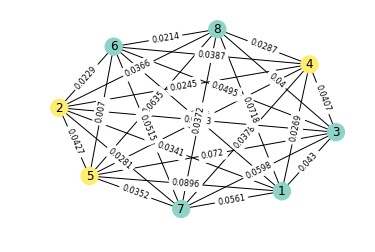

In [10]:
np.random.seed(123)
pos = nx.spring_layout(G, k = 0.5, iterations = 100)
nx.draw_networkx(G, pos, node_color = jdScore, cmap = plt.cm.Set3)
nx.draw_networkx_edge_labels(G, pos, edge_labels = weightDict, font_size = 8)
plt.axis('off')
plt.show()
plt.close()

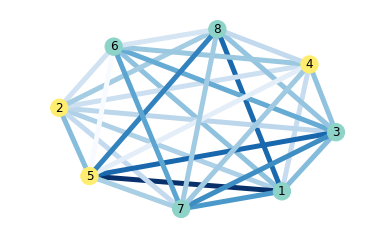

In [11]:
np.random.seed(123)
pos = nx.spring_layout(G, k = 0.5, iterations = 100)
nx.draw_networkx(G, pos, node_color = jdScore, cmap = plt.cm.Set3, 
                 edge_color = [d['weight'] for (u, v, d) in G.edges(data = True)], width = 5.0, 
                 edge_cmap = plt.cm.Blues)
#nx.draw_networkx_edge_labels(G, pos, edge_labels = weightDict, font_size = 8)
plt.axis('off')
plt.show()
plt.close()

# Group 2, 4 and 5 are strong candidates, and group 4 is most similar to group 7 (our group)
# Hence group 4 is our strongest competitor

In [12]:
# Average similarity between groups + 1 std dev

allWeights = [d['weight'] for (u, v, d) in G.edges(data = True)]
print(np.mean(allWeights) + np.std(allWeights))

0.0589594875608


In [13]:
"""
Descriptive Stats

"""

# Your code goes here.
jdSim = nx.get_node_attributes(G, 'jdSimilarity')
rowlist = []
for groupNo in groups:
    row = []
    row.append(groupNo)
    listNeighbours = G.neighbors(groupNo)
    #row.append(len([node for node in listNeighbours if G[groupNo][node]['weight'] > (np.mean(allWeights) + np.std(allWeights))]))
    sim = [G[groupNo][node]['weight'] for node in listNeighbours]
    if len(sim) == 0:
        row.append(0)
        row.append(0)
    else:
        row.append(np.mean(sim))
        row.append(np.max(sim))
    row.append(len(groupImptNouns[groupNo]))
    row.append(len(groupImptVerbs[groupNo]))
    row.append(jdSimilarity[groupNo])
    rowlist.append(row)

groupDF = pd.DataFrame(rowlist, columns = ['group', 'avgSim', 'maxSim', 'nounsSize', 'verbsSize', 'jdSimilarity'])

groupDF.to_csv('D:\\Imperial MSc\\Electives\\Workforce Analytics\\Coursework\\GroupMetrics.csv', index = False)

groupDF

,group,avgSim,maxSim,nounsSize,verbsSize,jdSimilarity
0,1,0.051787,0.089552,65,39,0.038043
1,2,0.031314,0.042735,47,33,0.043750
2,3,0.047892,0.072000,64,28,0.034682
3,4,0.030410,0.040698,62,29,0.041420
4,5,0.046505,0.089552,25,18,0.056452
5,6,0.033141,0.051546,62,39,0.016216
6,7,0.043689,0.059783,75,30,0.026738
7,8,0.042752,0.071823,61,30,0.028736


### Limitations

- No spell checker
- No synonyms check
- Assessment is based on what interviewees wrote, not evidence-based
- No assessment of actual skill level, only word matching
- Important keywords might be filtered as stopWords (in the percentile matching)
- No phrase matching (e.g. 'machine learning')
- Exact keyword matching is not good in assessing soft skills and other experiences, e.g. internship experience, marketing experience, etc

## Part 2

In [14]:
# Load all Ethnic Surnames
all_eth = pd.read_csv('D:\\Imperial MSc\\Electives\\Workforce Analytics\\Lecture 4\\Workshop\\D4 ethnic_surnames.csv')

allEthnics = all_eth.columns.values

# Create metaphone version
all_eth_metaphone = {}
for ethnic in allEthnics:
    all_eth_metaphone[ethnic] = []
    for lastName in all_eth[ethnic]:
        all_eth_metaphone[ethnic].append(jellyfish.metaphone(lastName))

In [15]:
## For complementary skills, we want low similarities and moderate diversity (lastname, educational level)

random.seed(12345)

eduLevel = {}
ethnic = {}
# Extract education level and ethnic groups from raw text
for groupNo in groups:
    # Raw Text for the group
    rawWordList = np.array(rawWords[groupNo])
    
    # Key word extraction for educational qualifications
    if 'phd' in rawWordList:
        eduLevel[groupNo] = 'phd'
    elif ('msc' in rawWordList) or ('masters' in rawWordList) or ('master' in rawWordList):
        eduLevel[groupNo] = 'masters'
    
    # Extract surname: its position is at the last word of the text
    surname = rawWordList[rawWordList != ''][-1]
    
    # Step 1: Exact surname matching, use the first match
    currEth = []
    for eth in allEthnics:
        if surname.upper() in all_eth[eth].as_matrix():
            currEth = [eth]
            break
    
    # Step 2: If there's no exact match, proceed with metaphone matching
    if len(currEth) == 0:
        
        metaphone_surname = jellyfish.metaphone(surname)
        for eth in allEthnics:
            if metaphone_surname in all_eth_metaphone[eth]:
                currEth.append(eth)
        
        # If there is 1 or more matching done using metaphone matching, pick a random ethnicity as match
        if len(currEth) > 0:
            randidx = random.randrange(len(currEth))
            ethnic[groupNo] = currEth[randidx]
        # If there is no metaphone match, classify as "Others"
        else:
            ethnic[groupNo] = 'Others'
    else:
        ethnic[groupNo] = currEth[0]


In [16]:
# Educational Level of each group
eduLevel

{1: 'masters',
 2: 'phd',
 3: 'masters',
 4: 'phd',
 5: 'masters',
 6: 'masters',
 7: 'masters',
 8: 'masters'}

In [17]:
# Ethnicity of each group
ethnic

{1: 'Others',
 2: 'Others',
 3: 'Chinese',
 4: 'English',
 5: 'Others',
 6: 'Indian',
 7: 'Chinese',
 8: 'Others'}

In [18]:
# Calculate diversity of pairs
diversity = {}

for key in possible_edges:
    diversity[key] = diversityCalc([ethnic[key[0]], eduLevel[key[0]]], [ethnic[key[1]], eduLevel[key[1]]])

In [19]:
diversity

{(1, 2): 0.5,
 (1, 3): 0.5,
 (1, 4): 1.0,
 (1, 5): 0.0,
 (1, 6): 0.5,
 (1, 7): 0.5,
 (1, 8): 0.0,
 (2, 3): 1.0,
 (2, 4): 0.5,
 (2, 5): 0.5,
 (2, 6): 1.0,
 (2, 7): 1.0,
 (2, 8): 0.5,
 (3, 4): 1.0,
 (3, 5): 0.5,
 (3, 6): 0.5,
 (3, 7): 0.0,
 (3, 8): 0.5,
 (4, 5): 1.0,
 (4, 6): 1.0,
 (4, 7): 1.0,
 (4, 8): 1.0,
 (5, 6): 0.5,
 (5, 7): 0.5,
 (5, 8): 0.0,
 (6, 7): 0.5,
 (6, 8): 0.5,
 (7, 8): 0.5}

In [20]:
# Focus on Group 7: our group
feasiblePairs = []
for key, value in diversity.items():
    if (7 in key) and (value != 0) and (value != 1):
        feasiblePairs.append(key)

In [21]:
for key in feasiblePairs:
    print(key, ", Diversity =", diversity[key], ", Similarity =", weightDict[key])

# Out of the below pairs (with sufficient diversity when pairing with Group 7), Group 5 is most dissimilar
# Hence group 5 complements the skills of Group 7

(6, 7) , Diversity = 0.5 , Similarity = 0.0515
(7, 8) , Diversity = 0.5 , Similarity = 0.0372
(5, 7) , Diversity = 0.5 , Similarity = 0.0352
(1, 7) , Diversity = 0.5 , Similarity = 0.0561


### Alternative Approach (Sales vs Engineer JDs)

In [22]:
functions = ['sales','engineer']

funcNouns = {}
funcVerbs = {}

# Sales and Engineer JD Processing
for function in functions:
    fname1 = "D:\\Imperial MSc\\Electives\\Workforce Analytics\\Coursework\\cover letters\\{}.txt".format(function)
    if os.path.isfile(fname1):
        with codecs.open(fname1, "r", encoding='utf-8', errors='ignore') as myfile:
            text = myfile.read().replace('\n', '')
            funcNouns[function] = extract_nouns(text)
            funcVerbs[function] = extract_verbs(text)
            # Lemmatize
            funcNouns[function] = lemmatise(funcNouns[function], pos = 'n')
            funcVerbs[function] = lemmatise(funcVerbs[function], pos = 'v')

"""
Remove Stop Words using NLTK stopwords
We don't remove frequent words in JD since they may contain important keywords (e.g. R, Python, Programming)
  
"""

# For JD, we don't filter the words that appear frequently, since they may indicate important job requirements (e.g. Python)
# Thus, we only filter out the common english stop words
jdImptNouns = set([word for word in jdNouns if word not in commonStopWords])
jdImptVerbs = set([word for word in jdVerbs if word not in commonStopWords])

funcImptNouns = {}
funcImptVerbs = {}

# Remove stop words from each firm's vocab
for function in functions:
    funcImptNouns[function]= list(set([word for word in funcNouns[function] if word not in commonStopWords]))
    funcImptVerbs[function]= list(set([word for word in funcVerbs[function] if word not in commonStopWords]))


In [23]:
"""
Similarities to engineer and sales JD
   
"""

salesSim = {}
engineerSim = {}
# Similarity is calculated using BOTH nouns and verbs matching
for groupNo in groups:
    salesSim[groupNo] = similarity(groupImptNouns[groupNo] + groupImptVerbs[groupNo], 
                                   funcImptNouns['sales'] + funcImptVerbs['sales'])
    engineerSim[groupNo] = similarity(groupImptNouns[groupNo] + groupImptVerbs[groupNo], 
                                      funcImptNouns['engineer'] + funcImptVerbs['engineer'])



In [24]:
# Average sales and engineer similarities
aveSalesSim = np.mean(list(salesSim.values()))
aveEngineerSim = np.mean(list(engineerSim.values()))

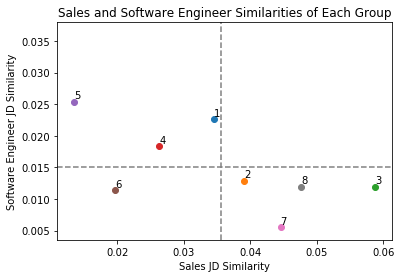

In [25]:
# Quadrant plot
for k in salesSim.keys():
    plt.scatter(salesSim[k], engineerSim[k], label = str(k))
    plt.annotate(str(k), (salesSim[k], engineerSim[k] + 0.0005))
plt.axhline(aveEngineerSim, color = 'grey', ls = 'dashed')
plt.axvline(aveSalesSim, color = 'grey', ls = 'dashed')
plt.xlabel('Sales JD Similarity')
plt.ylabel('Software Engineer JD Similarity')
plt.title('Sales and Software Engineer Similarities of Each Group')
plt.show()
plt.close()

We can see that our group (group 7) has high similarity to Sales JD but low similarity to Engineer JD. Hence the complement character will be someone with high engineer capabilities. In the top half of the graph, both 1 and 5 are eligibile. We pick 5 since he/she has higher engineer similarity, while we already have the sales capability.